['Department of Civil and Environmental Engineering, University of Alberta, Edmonton, AB  T6G 1H9, Canada', 'Department of Civil and Construction Engineering, Western Michigan University, Kalamazoo, MI  49008-5316, United States', 'Department of Civil and Environmental Engineering, University of Alberta, Edmonton, AB  T6G 1H9, Canada', 'Department of Civil and Environmental Engineering, University of Alberta, Edmonton, AB  T6G 1H9, Canada']
['Computer Science Department, University of Torino, C.so Svizzera, 185, Torino, 10149, Italy', 'Department of Cultures, Politics and Society, University of Torino, Torino, Italy']
['Department for Construction Project Management, Faculty of Civil Engineering, University of Belgrade, Bul. kralja Aleksandra 73, Belgrade, 11120, Serbia', 'Hasso Plattner Institute, Faculty of Digital Engineering, Computer Graphics Systems Group, University of Potsdam, Prof.-Dr.-Helmert-Strasse 2-3, Potsdam, 14482, Germany', 'Hasso Plattner Institute, Faculty of Digital

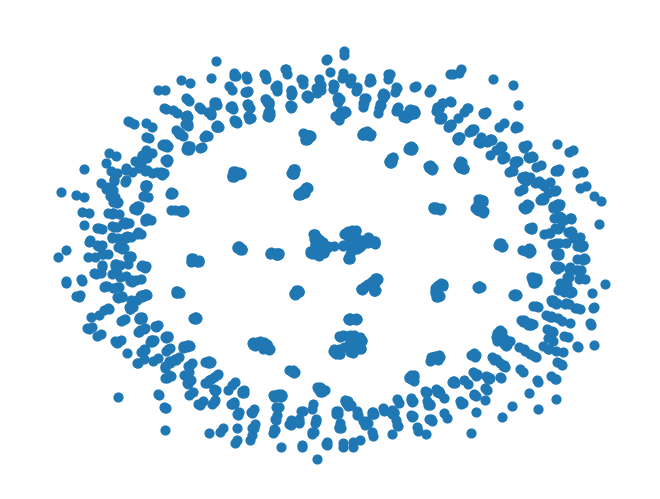

In [5]:
import csv
import json
import itertools
import networkx as nx
from networkx.readwrite import json_graph

# Path to your CSV file
csv_file_path = 'data_scopus.csv'  # Replace with your actual file path
author_graph = nx.Graph()

# Helper function to parse author name and country
def parse_author_affiliations(author_affiliations):
    country_list = []
    affiliation_list = []
    authors = author_affiliations.strip().split(';')  # Split each author by semicolon
    
    for author in authors:
        if author.strip():  # Skip empty entries
            # Split from the right to isolate the country (last part)
            parts = author.strip().rsplit(',', 1)
            country = parts[1].strip() if len(parts) == 2 and parts[1].strip() else "None"
            country_list.append(country)

            # Remove the author's name (first two parts after splitting by comma)
            affiliation_parts = author.split(',', 2)
            if len(affiliation_parts) >= 3:
                affiliation = affiliation_parts[2].strip()  # Get everything after the name
            else:
                affiliation = affiliation_parts[-1].strip()  # In case of unexpected structure
            
            affiliation_list.append(affiliation)  # Add cleaned affiliation to the list
    
    print(affiliation_list)

    return country_list, affiliation_list


# Initialize nodes and edges lists
author_nodes = []
author_edges = []
unique_author_ids = []  # To track unique author IDs and avoid duplicates

# Step 1: Parse the CSV file and build nodes and edges
with open(csv_file_path, mode='r', encoding='utf-8') as file:
    reader = csv.DictReader(file)
    
    for row in reader:
        author_countries, author_affiliations = parse_author_affiliations(row['Authors with affiliations'])
        author_names = row['Authors'].split(',')
        author_ids = [id.strip() for id in row['Author(s) ID'].split(';') if id.strip()]
        publication_id = row['EID']  # Unique identifier for each publication
        if not author_countries or not row['Year'] or not author_names:
            continue
        
        # Step 2: Add nodes for each unique author ID
        for i, author_id in enumerate(author_ids):
            author_id = author_id.strip()
            author_name = author_names[i].strip()
            country = author_countries[i].strip()
            affiliation = author_affiliations[i].strip()

            if author_id not in unique_author_ids:
                # Add new node if author ID is unique
                author_node = (author_id, {
                    'name': author_name,
                    'country': country,
                    'affiliation': affiliation,
                })
                author_nodes.append(author_node)
                unique_author_ids.append(author_id)
                        
        for coauthor_pair in itertools.combinations(author_ids, 2):
            if (coauthor_pair not in author_edges) and (coauthor_pair[::-1] not in author_edges):  # Prevent duplicate edges
                author_edges.append(coauthor_pair)

author_graph = nx.Graph()                
author_graph.add_nodes_from(author_nodes)
author_graph.add_edges_from(author_edges)

# Save graph to GraphML file
graphml_output_path = 'author_network.graphml'
nx.write_graphml(author_graph, graphml_output_path)

# Draw the graph layout
graph_layout = nx.drawing.spring_layout(author_graph)
nx.draw(author_graph, pos=graph_layout, node_size=40)

# Step 4: Save nodes and links into a JSON file
json_output_path = 'author_network.json'  # Destination for your JSON file
with open(json_output_path, 'w', encoding='utf-8') as json_file:
    json.dump(json_graph.node_link_data(author_graph), json_file)

